In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from mst_prim import prim_mst
from nemo import evaluate_nemo
import util
from util import lighten_color, get_max_by_thresh
import seaborn as sns
from util import centroid_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist, setup_topology

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)

device_number = 1000 + 1
avg = 30
c_capacity = 30
max_resources = device_number * avg - 100

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
X_dim = [-10, 110]
Y_dim = [-60, 60]
centers = 40
weights = [(i, i + 1) for i in range(1, 11)]

H, bins = get_lognorm_hist()
prim_df, coords, c_coords, base_col, slot_columns, sums = setup_topology(H, max_resources, c_capacity, centers,
                                                                         X_dim_range, Y_dim_range, device_number - 1,
                                                                         seed=seed, weights=(1, 50))

eval_matrix = {}

In [3]:
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,19.383905,7.406120,0.000000,coordinator,9223372036854775807,0,30,30,30,30,30,30,30,30,30,30,30,30
1,67.743232,-14.007158,52.888118,worker,9223372036854775807,1,30,29,30,32,26,24,35,29,64,28,33,27
2,5.220579,-15.467092,26.903228,worker,9223372036854775807,1,30,32,29,26,26,22,37,30,65,28,38,0
3,43.521014,41.129903,41.471599,worker,9223372036854775807,5,30,31,33,31,27,37,23,20,20,19,22,5
4,14.195029,1.412734,7.927491,worker,9223372036854775807,2,30,29,30,37,36,42,20,32,37,13,103,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,9223372036854775807,2,30,31,28,27,35,31,21,33,16,38,13,67
997,39.672067,34.499402,33.847532,worker,9223372036854775807,50,30,31,31,27,27,39,33,21,16,14,8,17
998,40.609309,23.985392,26.933066,worker,9223372036854775807,33,30,32,33,34,28,40,31,48,17,14,22,11
999,31.878351,34.859971,30.163307,worker,9223372036854775807,4,30,31,30,33,34,41,23,18,60,10,55,0


In [4]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())

Required: 6154 Available: 30030


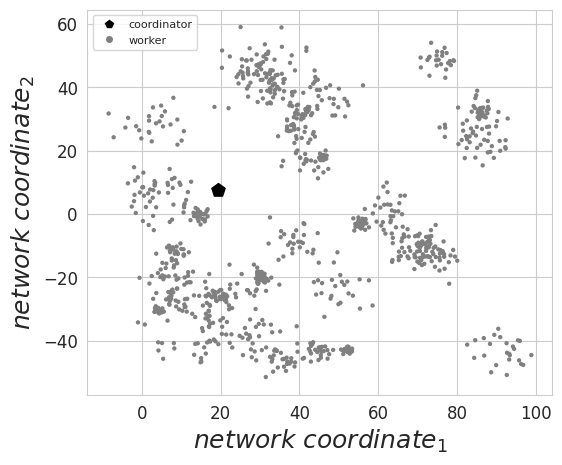

In [5]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

tcolors = {"coordinator": "red", "worker": "grey"}
scat2 = prim_df.plot.scatter(ax=ax1, x="x", y="y", c=prim_df["type"].map(tcolors),
                             s=prim_df["capacity_" + str(100)] * 0.15)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=18)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=18)
ax1.scatter(coords[0, 0], coords[0, 1], color='grey')
plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_plain.svg", bbox_inches="tight")

#plot coordinators
ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')
ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
#ax1.set_title('NES Topology in a Cost Space')
plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")
plt.show()

5
10
15
20
25
30
[0.4366208489016169, 0.4578903649217423, 0.49992119195341034, 0.5108058793595069, 0.5299915524594493, 0.5267786941386162, 0.5009227602975688, 0.4841569002362528, 0.5183732388175919, 0.5089759274551251, 0.5117896205451166, 0.5105253622412232, 0.5293334983994091, 0.5168366205208105, 0.5165437266976227, 0.5328298970637009, 0.5141888446038513, 0.5166973296098755, 0.508212798745317, 0.49082279488661057, 0.5001087379532659, 0.513173374582429, 0.492597708410025, 0.47799126712529283, 0.4678521377629234, 0.47591984822325606, 0.4667828622462073, 0.4670538328025685, 0.45841087810116826]
0.4828298970637009
Optimal k is  22


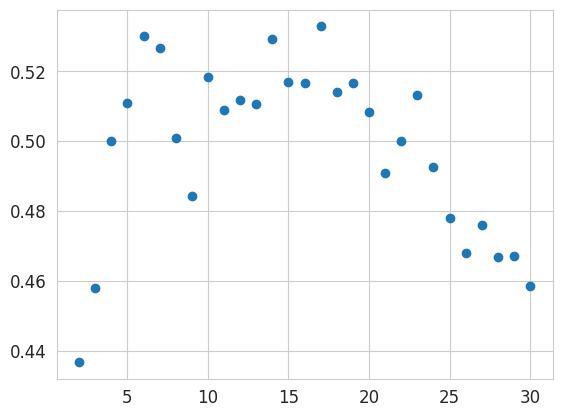

In [6]:
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(kmin, kmax + 1):
    if k % 5 == 0:
        print(k)
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
    labels = kmeans.labels_
    sil.append(silhouette_score(coords, labels, metric='euclidean'))

print(sil)

#opt_k = np.argmax(sil)
#opt_k = kmin + opt_k
opt_k = get_max_by_thresh(sil, 0.05)
print("Optimal k is ", opt_k)

cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
labels = cluster_alg.labels_
centroids = cluster_alg.cluster_centers_
plt.scatter(x=list(range(kmin, kmax + 1)), y=sil)

prim_df["cluster"] = labels
prim_df.loc[0, "cluster"] = -1

In [7]:
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

color_list = sns.color_palette(n_colors=no_clusters)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
color_list

Estimated no. of clusters: 22
Estimated no. of noise points: 0


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

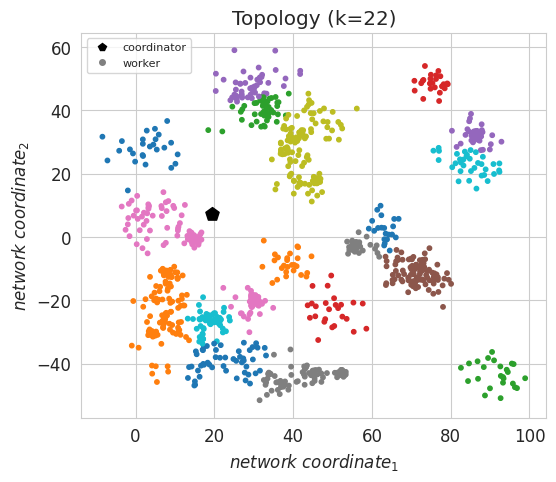

In [8]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')

plt.savefig("plots/sim_1000/sim" + str(device_number - 1) + "_" + str(no_clusters) + ".svg", bbox_inches="tight")
plt.title('Topology (k=' + str(no_clusters) + ")")

plt.show()

### Experiment 2b: NEMO Aggregation with Density-based Grouping

In [167]:
# assign nodes to previous clustering alg
iterations = 10
W = 80
L = 100

slot_col = "capacity_100"
eval_name = "nemo"
weight_col = "weight"
df_dict = evaluate_nemo(prim_df, coords, centroids, W, L, ["base", slot_col], iterations=iterations,
                                 weight_col=weight_col, weighting="spring")

Starting nemo for base with spring and weight
Starting nemo for capacity_100 with spring and weight


In [168]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent
0,0,19.383905,7.406120,coordinator,-1,0,0,30,1,29,0
1,1,67.743232,-14.007158,worker,15,1,1,30,30,0,175
2,2,5.220579,-15.467092,worker,11,1,1,30,30,0,132
3,3,43.521014,41.129903,worker,18,5,5,30,30,0,806
4,4,14.195029,1.412734,worker,6,2,2,30,0,1,458
...,...,...,...,...,...,...,...,...,...,...,...
2171,998,40.609309,23.985392,worker,8,33,12,30,0,13,757
2172,998,40.609309,23.985392,worker,8,33,21,30,0,13,630
2173,999,31.878351,34.859971,worker,2,4,4,30,0,1,532
2174,999,31.878351,34.859971,worker,2,4,4,30,0,1,741


In [169]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent
0,0,19.383905,7.406120,coordinator,-1,0,0,30,1,29,0
105,52,45.837019,18.439606,worker,8,1,1,30,11,28,0
106,52,45.837019,18.439606,worker,8,1,1,30,11,28,0
107,52,45.837019,18.439606,worker,8,1,1,30,11,28,0
348,155,61.350853,8.617322,worker,0,1,1,30,16,28,0
603,249,23.743369,-25.254588,worker,9,1,1,30,10,28,0
647,260,9.019107,29.797250,worker,10,1,1,30,3,28,0
762,301,46.111016,13.094182,worker,8,1,1,30,20,28,0
858,338,13.998301,-0.843480,worker,6,1,1,30,11,28,0
859,338,13.998301,-0.843480,worker,6,1,1,30,11,28,0


In [170]:
df_overloaded = df.groupby(['parent'])['used_weight'].sum()
df_capacity = df.iloc[df["parent"].unique().tolist()]["total_capacity"]
result = pd.merge(df_capacity, df_overloaded, left_index=True, right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,total_capacity,used_weight,delta
parent,,,


In [171]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

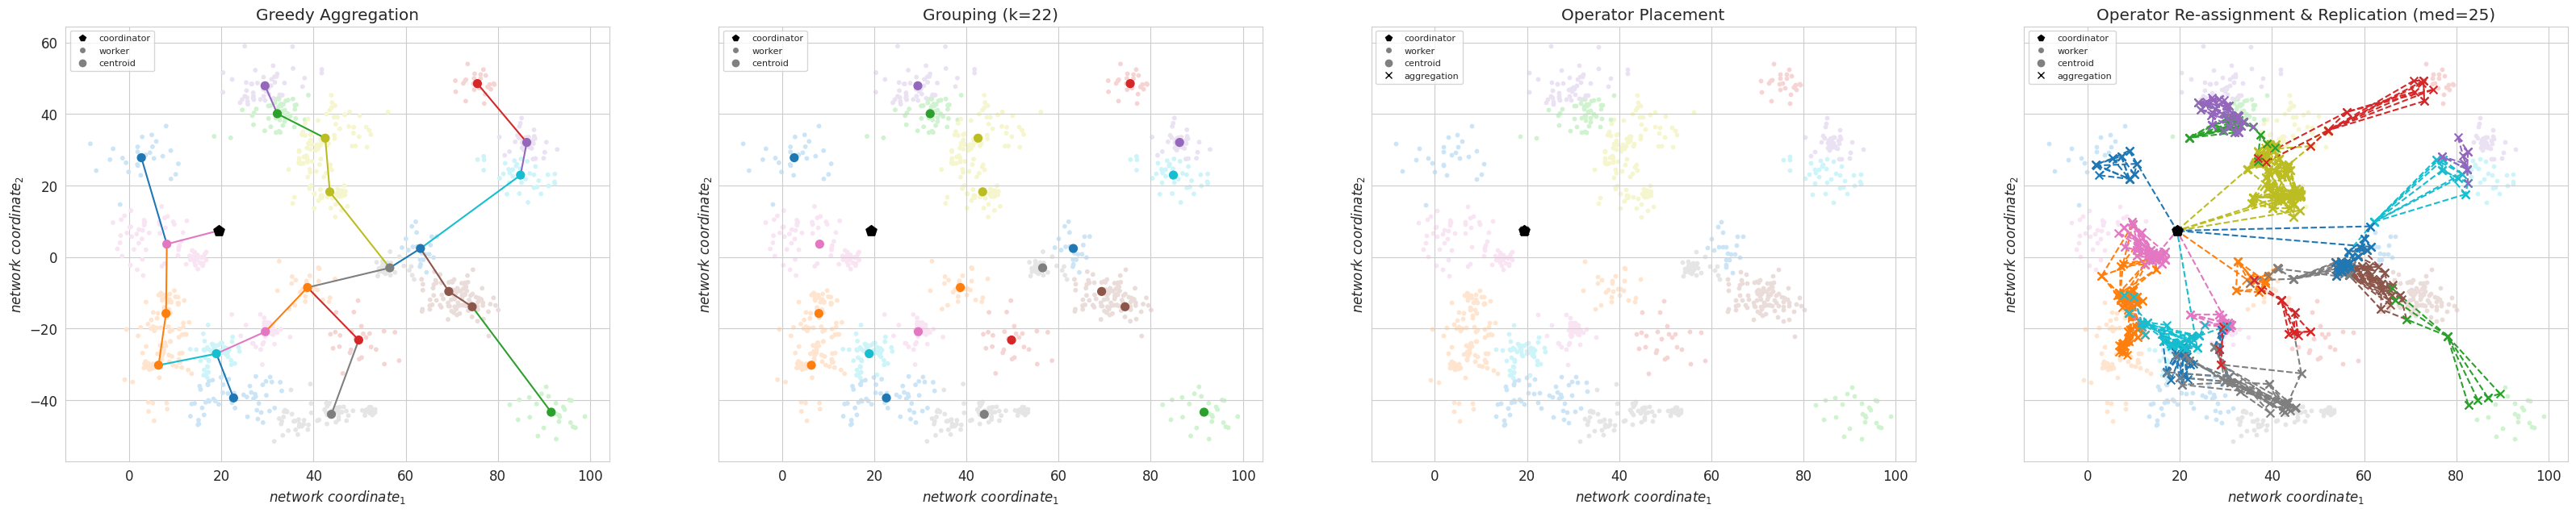

In [172]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.2

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)

ax2.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)
ax2.set_title('Grouping (k=' + str(opt_k) + ")")
ax2.set_xlabel('$network$ $coordinate_1$')
ax2.set_ylabel('$network$ $coordinate_2$')

#plot our solutions
util.plot2(ax3, prim_df, df_dict["base"], colors, lval=lval)
util.plot2(ax4, prim_df, df_dict[slot_col], colors, lval=lval)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("Operator Placement")
ax4.set_title("Operator Re-assignment & Replication (med=" + str(25) + ")")

plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

In [225]:
df = df_dict["base"]
df[df["cluster"] == -2]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,used_capacity,parent
25,25,82.599536,-41.295540,worker,-2,2,2,9223372036854775807,9223372036854775716,0
132,132,10.037699,-11.087989,worker,-2,1,1,9223372036854775807,9223372036854775418,0
175,175,61.844644,-6.225139,worker,-2,25,25,9223372036854775807,9223372036854775464,0
180,180,75.610322,27.287765,worker,-2,1,1,9223372036854775807,9223372036854775680,0
238,238,40.229852,17.690823,worker,-2,1,1,9223372036854775807,9223372036854775347,0
277,277,53.701273,-1.423096,worker,-2,3,3,9223372036854775807,9223372036854775624,0
282,282,39.319591,-35.500336,worker,-2,1,1,9223372036854775807,9223372036854775355,0
314,314,66.080270,-10.699930,worker,-2,1,1,9223372036854775807,9223372036854775571,0
374,374,76.940846,24.326371,worker,-2,13,13,9223372036854775807,9223372036854775622,0
393,393,8.904296,-23.613882,worker,-2,9,9,9223372036854775807,9223372036854775390,0


In [139]:
a =[42.56, 33.28]
b = c_coords
util.calc_opt(a, c_coords, w1=0.1)

array([38.7219527 , 28.97306014])

NameError: name 'new_paths_flat' is not defined

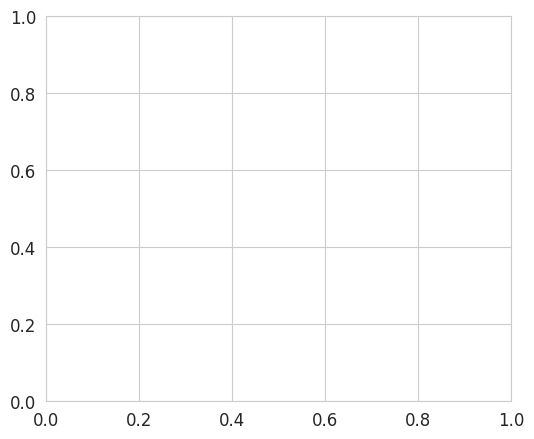

In [136]:
fig = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(fig, new_paths_flat["base"], agg_dict_flat["base"], c_coords, cluster_coords, coords, colors, labels,
          lval=lval)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


fig.set_xlabel('$network$ $coordinate_1$')
fig.set_ylabel('$network$ $coordinate_2$')

#plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")
plt.show()

Distribution of workload:  4.0959 %


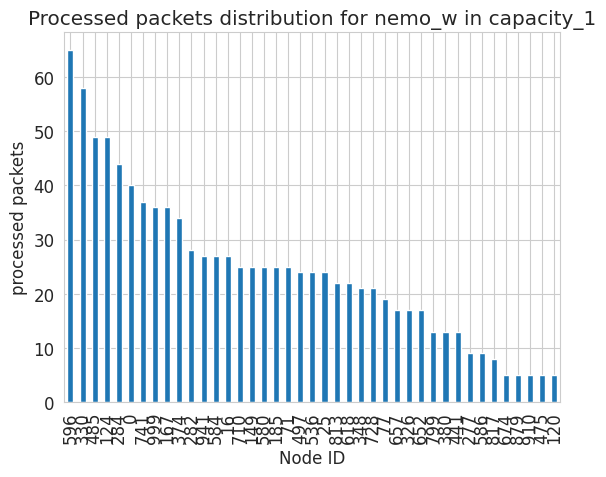

In [73]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

## Evaluation

In [101]:
eval_matrix.keys()

dict_keys(['nemo_w'])

In [102]:
eval_matrix["nemo_w"].keys()

dict_keys(['base', 'capacity_1'])

In [107]:
eval_colors = {
    "nemo_w": colors[5],
    "nemo_w_base": colors[6]
}

### Latency

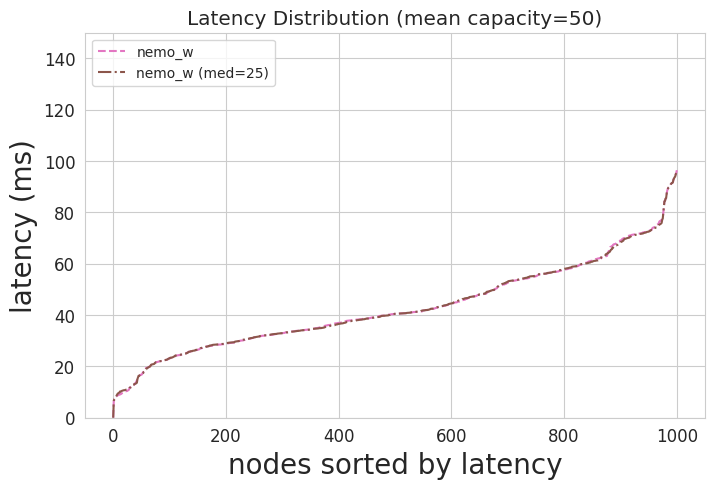

Means:  {'nemo_w': 43.1, 'nemo_w (med=25)': 43.08}
Quantiles:  {'nemo_w': 69.08, 'nemo_w (med=25)': 68.41}


In [109]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}
last_med_label = "25"

for l in eval_matrix.keys():
    emat = eval_matrix[l]

    i = 0
    for k, df in emat.items():
        #if i % 50 == 0:
        if l == "nemo" and k == "base":
            sv = df["latency_distribution"].sort_values()
            sv.plot(ax=ax1, use_index=False, label=l + " (base)", color=eval_colors[l + "_base"], linestyle="--")
        elif k == "base":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l] = round(sv.quantile(0.9), 2)
            mean_dict[l] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[l + "_base"], linestyle="--")
        elif k == "capacity_1":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l + " (med=" + last_med_label + ")"] = round(sv.quantile(0.9), 2)
            mean_dict[l + " (med=" + last_med_label + ")"] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l + " (med=" + last_med_label + ")", color=eval_colors[cl],
                    linestyle="-.")
        i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)